In [99]:
import pandas as pd
import geopandas as gpd
from sklearn.metrics import precision_score, recall_score,mean_squared_error,r2_score,confusion_matrix
from scipy import stats
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
pred = pd.read_csv("/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/run1/classification_results.csv")

In [101]:
pred.groupby('type_pred').size()

type_pred
asphalt          4439
concrete          449
paving_stones     776
sett              489
unpaved           268
dtype: int64

In [102]:
gt = gpd.read_file("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/Berlin/Radverkehr_priorisierungskonzept/priorisierungskonzept_validation.gpkg", 
                   dtype={"id": int})
gt = gt[["id", "gid", "ELEM_NR", "checked", "type_ground_truth", "quality_ground_truth"]]

In [104]:
run = 1
description = "disaggregated by road scenery"

In [106]:
pred = gpd.read_file(f"/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/run{run}/berlin_ways_pred_cycleways.shp")
pred = pred[["ID", "TYPE_PRED", "AVG_CLASS_", "AVG_QUALIT"]]
pred.rename(columns={"ID":"id", "TYPE_PRED": "type_pred", "AVG_CLASS_": "avg_class_prob", "AVG_QUALIT": "avg_quality_pred"}, inplace=True)

df = gt.set_index("id").join(pred.set_index("id"))
df = df[df.type_pred.notna()]
df = df[df.type_ground_truth.notna()]
acc_type = (df.type_pred == df.type_ground_truth).sum() / len(df)
acc_type

0.7808988764044944

#### Confusion matrix surface types

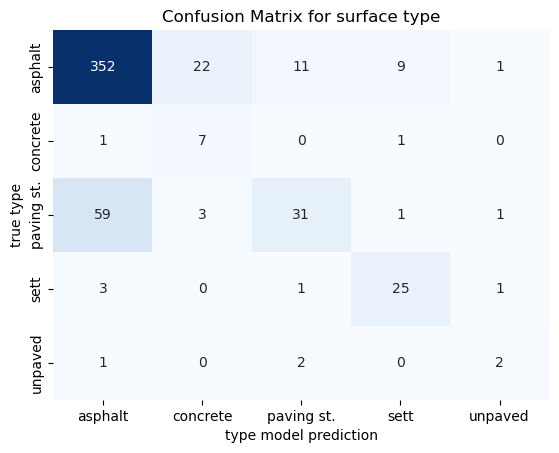

In [107]:
cm = confusion_matrix(df.type_ground_truth, df.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_run10.png", transparent=True, bbox_inches='tight')
plt.show()

### Quality

In [108]:
df["quality_ground_truth_float"] = df.quality_ground_truth.map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})

In [109]:
def quality_to_class(quality_float):
    if quality_float < 1.5:
        return "excellent"
    elif quality_float < 2.5:
        return "good"
    elif quality_float < 3.5:
        return "intermediate"
    elif quality_float < 4.5:
        return "bad"
    elif quality_float < 5.5:
        return "very_bad"
    else:
        return None
    
df["quality_pred"] = df.avg_quality_pred.apply(quality_to_class)

In [110]:
df["deviation"] = df.quality_ground_truth_float - df.avg_quality_pred
df.deviation.describe()

count    533.000000
mean      -0.003027
std        0.669774
min       -1.641919
25%       -0.463422
50%        0.027469
75%        0.401073
max        2.255874
Name: deviation, dtype: float64

In [111]:
df_quality.quality_ground_truth_float

id
2       2.0
4       4.0
5       1.0
7       2.0
8       3.0
       ... 
7729    3.0
7730    3.0
7731    1.0
7732    2.0
7734    2.0
Name: quality_ground_truth_float, Length: 503, dtype: float64

In [112]:
df_quality = df[df.quality_ground_truth_float.notna() & df.avg_quality_pred.notna()] 
mse = mean_squared_error(df_quality.quality_ground_truth_float, df_quality.avg_quality_pred)
mse

0.4477649822223961

<Axes: >

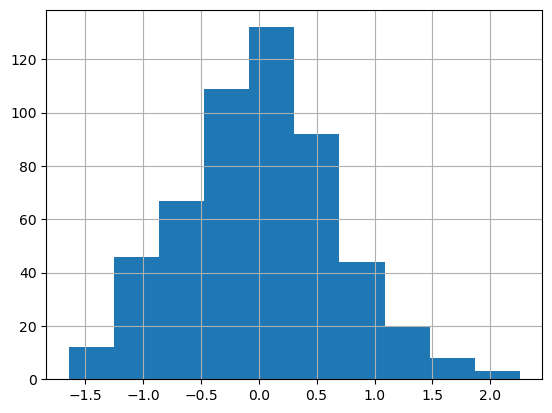

In [113]:
df.deviation.hist()

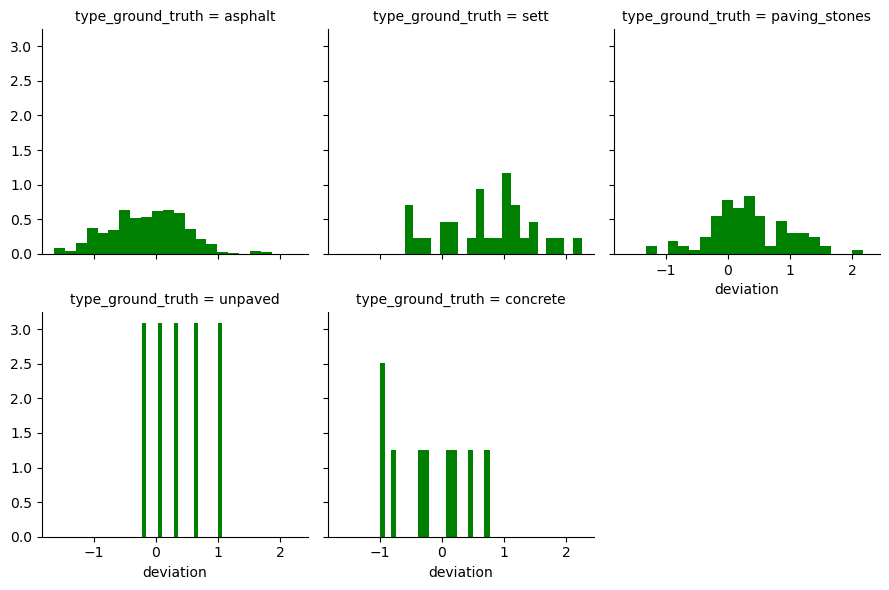

In [114]:
# Create a FacetGrid for histograms
g_hist = sns.FacetGrid(df, col="type_ground_truth", col_wrap=3)

# Map histogram for a deviation for each surface type
g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

plt.show()

# positive deviation means that the quality is overestimated

In [115]:
results_df = pd.DataFrame({
    'run':run,
    'description': description,
    'type_accuracy': [round(acc_type, 3)],
    'quality_mean_squared_error': [round(mse, 3)]
})

# Append results to CSV
csv_file_path = '/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/aggregation_alg_results.csv'
results_df.to_csv(csv_file_path, mode='a', header=not pd.io.common.file_exists(csv_file_path), index=False)
